In [2]:
!pip install catboost

     |████████████████████████████████| 66.1MB 43kB/s 


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef

from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold,KFold,GroupKFold
from sklearn.utils import resample
from catboost import CatBoostClassifier
from sklearn.preprocessing import KBinsDiscretizer

In [18]:
sub1 = pd.read_csv("/content/896_102953_us_lgb_vecstack_under_over.csv")
sub2 = pd.read_csv("/content/896_102953_us_lgb_vecstack_under_over_onefe_orwl1sg.csv")
sub3 = pd.read_csv("/content/896_564459_us_over_stackboost_1.csv")
sub4 = pd.read_csv("/content/896_564459_us_catboost_1.csv")

In [19]:
sub1['Sub_pred'] = (sub1['Response'] + sub4['Response']) / 2

In [20]:
sub1.head()

,id,Response,Sub_pred
0,381110,0.001775,0.003282
1,381111,0.528741,0.632323
2,381112,0.495901,0.600758
3,381113,0.026980,0.042422
4,381114,0.000784,0.001799


In [21]:
sub1 = sub1[['id','Sub_pred']]

In [22]:
sub1.columns = ['id','Response']

In [23]:
sub1.to_csv("avg_submission2.csv",index=False)

# Data Analysis

In [26]:
train = pd.read_csv("/content/drive/My Drive/JH_CrossSellPrediction/train.csv")
test = pd.read_csv("/content/drive/My Drive/JH_CrossSellPrediction/test.csv")
submission = pd.read_csv("/content/drive/My Drive/JH_CrossSellPrediction/sample_submission_iA3afxn.csv")

## Check null and basic class counts and so on

In [27]:
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [28]:
test.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

In [29]:
train['Response'].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

In [30]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# Basic normalization, ohe and label encoding

In [31]:
## We will label encode for variable Vehicle_Age, Vehicle Damage
## OHE for Male /Female (as it is not ordinal)
## Age, AnnualPremium,Vintage standardization (z value)

In [32]:
def combine_df(train,test):
  train['is_train'] = 1
  test['is_train'] = 0
  return pd.concat([train,test],axis=0)

In [33]:
combined = combine_df(train,test)

In [34]:
combined['Vehicle_Age'].value_counts()

1-2 Year     267015
< 1 Year     219805
> 2 Years     21326
Name: Vehicle_Age, dtype: int64

In [35]:
combined['Vehicle_Damage'].value_counts()

Yes    256248
No     251898
Name: Vehicle_Damage, dtype: int64

In [36]:
vehicle_age = {"< 1 Year": 1,
               "1-2 Year": 2,
               "> 2 Years":3}
vehicle_damage = {"Yes":1,"No":0}

combined['Vehicle_Age'] = combined['Vehicle_Age'].map(vehicle_age)
combined['Vehicle_Damage'] = combined['Vehicle_Damage'].map(vehicle_damage)

In [37]:
combined['Gender'].value_counts()

Male      274325
Female    233821
Name: Gender, dtype: int64

In [38]:
combined = pd.get_dummies(combined,columns=['Gender'])

In [39]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,0,1
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,0,1
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,0,1
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,0,1
4,5,29,1,41.0,1,1,0,27496.0,152.0,39,0.0,1,1,0


In [40]:
def z_score(x, x_mean, x_std):
  return (x - x_mean) / x_std

In [41]:
# Age_mean = combined['Age'].mean()
# Age_std = combined['Age'].std()
# combined['Age'] = combined['Age'].apply(z_score, args=(Age_mean, Age_std))

In [42]:
# Premium_mean = combined['Annual_Premium'].mean()
# Premium_std = combined['Annual_Premium'].std()
# combined['Annual_Premium'] = combined['Annual_Premium'].apply(z_score, args=(Premium_mean, Premium_std))

In [43]:
# Vintage_mean = combined['Vintage'].mean()
# Vintage_std = combined['Vintage'].std()
# combined['Vintage'] = combined['Vintage'].apply(z_score, args=(Vintage_mean, Vintage_std))

In [44]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,0,1
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,0,1
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,0,1
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,0,1
4,5,29,1,41.0,1,1,0,27496.0,152.0,39,0.0,1,1,0


In [45]:
combined.shape

(508146, 14)

In [46]:
combined.drop_duplicates().shape

(508146, 14)

# Feature Engineering

In [47]:
combined['mean_Age_per_region_code']=combined.groupby(['Region_Code'])['Age'].transform('mean')
combined['sum_Age_per_region_code']=combined.groupby(['Region_Code'])['Age'].transform('sum')
combined['max_Age_per_region_code']=combined.groupby(['Region_Code'])['Age'].transform('max')
combined['min_Age_per_region_code']=combined.groupby(['Region_Code'])['Age'].transform('min')

In [48]:
combined['mean_Annual_Premium_per_region_code']=combined.groupby(['Region_Code'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_region_code']=combined.groupby(['Region_Code'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_region_code']=combined.groupby(['Region_Code'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_region_code']=combined.groupby(['Region_Code'])['Annual_Premium'].transform('min')

In [49]:
combined['mean_Vintage_per_region_code']=combined.groupby(['Region_Code'])['Vintage'].transform('mean')
combined['sum_Vintage_per_region_code']=combined.groupby(['Region_Code'])['Vintage'].transform('sum')
combined['max_Vintage_per_region_code']=combined.groupby(['Region_Code'])['Vintage'].transform('max')
combined['min_Vintage_per_region_code']=combined.groupby(['Region_Code'])['Vintage'].transform('min')

In [50]:
combined['mean_Age_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Age'].transform('mean')
combined['sum_Age_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Age'].transform('sum')
combined['max_Age_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Age'].transform('max')
combined['min_Age_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Age'].transform('min')

In [51]:
combined['mean_Annual_Premium_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('min')

In [52]:
combined['mean_Vintage_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Vintage'].transform('mean')
combined['sum_Vintage_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Vintage'].transform('sum')
combined['max_Vintage_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Vintage'].transform('max')
combined['min_Vintage_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Vintage'].transform('min')

In [53]:
combined['mean_Age_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Age'].transform('mean')
combined['sum_Age_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Age'].transform('sum')
combined['max_Age_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Age'].transform('max')
combined['min_Age_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Age'].transform('min')

In [54]:
combined['mean_Annual_Premium_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Annual_Premium'].transform('min')

In [55]:
combined['mean_Vintage_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Vintage'].transform('mean')
combined['sum_Vintage_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Vintage'].transform('sum')
combined['max_Vintage_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Vintage'].transform('max')
combined['min_Vintage_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Vintage'].transform('min')

In [56]:
combined['mean_Age_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Age'].transform('mean')
combined['sum_Age_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Age'].transform('sum')
combined['max_Age_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Age'].transform('max')
combined['min_Age_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Age'].transform('min')

In [57]:
combined['mean_Annual_Premium_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Annual_Premium'].transform('min')

In [58]:
combined['mean_Vintage_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Vintage'].transform('mean')
combined['sum_Vintage_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Vintage'].transform('sum')
combined['max_Vintage_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Vintage'].transform('max')
combined['min_Vintage_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Vintage'].transform('min')

In [59]:
combined['mean_Age_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Age'].transform('mean')
combined['sum_Age_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Age'].transform('sum')
combined['max_Age_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Age'].transform('max')
combined['min_Age_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Age'].transform('min')

In [60]:
combined['mean_Annual_Premium_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Annual_Premium'].transform('min')

In [61]:
combined['mean_Vintage_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Vintage'].transform('mean')
combined['sum_Vintage_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Vintage'].transform('sum')
combined['max_Vintage_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Vintage'].transform('max')
combined['min_Vintage_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Vintage'].transform('min')

In [62]:
combined['mean_Age_per_Driving_License']=combined.groupby(['Driving_License'])['Age'].transform('mean')
combined['sum_Age_per_Driving_License']=combined.groupby(['Driving_License'])['Age'].transform('sum')
combined['max_Age_per_Driving_License']=combined.groupby(['Driving_License'])['Age'].transform('max')
combined['min_Age_per_Driving_License']=combined.groupby(['Driving_License'])['Age'].transform('min')

In [63]:
combined['mean_Annual_Premium_per_Driving_License']=combined.groupby(['Driving_License'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_Driving_License']=combined.groupby(['Driving_License'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_Driving_License']=combined.groupby(['Driving_License'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_Driving_License']=combined.groupby(['Driving_License'])['Annual_Premium'].transform('min')

In [64]:
combined['mean_Vintage_per_Driving_License']=combined.groupby(['Driving_License'])['Vintage'].transform('mean')
combined['sum_Vintage_per_Driving_License']=combined.groupby(['Driving_License'])['Vintage'].transform('sum')
combined['max_Vintage_per_Driving_License']=combined.groupby(['Driving_License'])['Vintage'].transform('max')
combined['min_Vintage_per_Driving_License']=combined.groupby(['Driving_License'])['Vintage'].transform('min')

In [65]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,mean_Vintage_per_vehicle_age,sum_Vintage_per_vehicle_age,max_Vintage_per_vehicle_age,min_Vintage_per_vehicle_age,mean_Age_per_vehicle_damage,sum_Age_per_vehicle_damage,max_Age_per_vehicle_damage,min_Age_per_vehicle_damage,mean_Annual_Premium_per_vehicle_damage,sum_Annual_Premium_per_vehicle_damage,max_Annual_Premium_per_vehicle_damage,min_Annual_Premium_per_vehicle_damage,mean_Vintage_per_vehicle_damage,sum_Vintage_per_vehicle_damage,max_Vintage_per_vehicle_damage,min_Vintage_per_vehicle_damage,mean_Age_per_Previously_Insured,sum_Age_per_Previously_Insured,max_Age_per_Previously_Insured,min_Age_per_Previously_Insured,mean_Annual_Premium_per_Previously_Insured,sum_Annual_Premium_per_Previously_Insured,max_Annual_Premium_per_Previously_Insured,min_Annual_Premium_per_Previously_Insured,mean_Vintage_per_Previously_Insured,sum_Vintage_per_Previously_Insured,max_Vintage_per_Previously_Insured,min_Vintage_per_Previously_Insured,mean_Age_per_Driving_License,sum_Age_per_Driving_License,max_Age_per_Driving_License,min_Age_per_Driving_License,mean_Annual_Premium_per_Driving_License,sum_Annual_Premium_per_Driving_License,max_Annual_Premium_per_Driving_License,min_Annual_Premium_per_Driving_License,mean_Vintage_per_Driving_License,sum_Vintage_per_Driving_License,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,154.740739,3300001,299,10,42.932081,11001260,85,20,30716.024137,7.870920e+09,540165.0,2630.0,154.250671,39526426,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,0,1,36.980970,456678,82,20,24465.445218,3.021238e+08,424578.0,2630.0,154.864442,1912421,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,49.017962,13088531,...,154.193603,41172005,299,10,34.613534,8719080,85,20,30390.091791,7.655203e+09,540165.0,2630.0,154.431119,38900890,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,154.740739,3300001,299,10,42.932081,11001260,85,20,30716.024137,7.870920e+09,540165.0,2630.0,154.250671,39526426,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,0,1,34.235480,422055,82,20,27655.183160,3.409331e+08,193637

In [66]:
combined['Vintage'].describe()

count    508146.000000
mean        154.340123
std          83.668793
min          10.000000
25%          82.000000
50%         154.000000
75%         227.000000
max         299.000000
Name: Vintage, dtype: float64

In [67]:
combined['Premium_by_age'] = combined['Annual_Premium'] / combined['Age']

In [68]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,sum_Vintage_per_vehicle_age,max_Vintage_per_vehicle_age,min_Vintage_per_vehicle_age,mean_Age_per_vehicle_damage,sum_Age_per_vehicle_damage,max_Age_per_vehicle_damage,min_Age_per_vehicle_damage,mean_Annual_Premium_per_vehicle_damage,sum_Annual_Premium_per_vehicle_damage,max_Annual_Premium_per_vehicle_damage,min_Annual_Premium_per_vehicle_damage,mean_Vintage_per_vehicle_damage,sum_Vintage_per_vehicle_damage,max_Vintage_per_vehicle_damage,min_Vintage_per_vehicle_damage,mean_Age_per_Previously_Insured,sum_Age_per_Previously_Insured,max_Age_per_Previously_Insured,min_Age_per_Previously_Insured,mean_Annual_Premium_per_Previously_Insured,sum_Annual_Premium_per_Previously_Insured,max_Annual_Premium_per_Previously_Insured,min_Annual_Premium_per_Previously_Insured,mean_Vintage_per_Previously_Insured,sum_Vintage_per_Previously_Insured,max_Vintage_per_Previously_Insured,min_Vintage_per_Previously_Insured,mean_Age_per_Driving_License,sum_Age_per_Driving_License,max_Age_per_Driving_License,min_Age_per_Driving_License,mean_Annual_Premium_per_Driving_License,sum_Annual_Premium_per_Driving_License,max_Annual_Premium_per_Driving_License,min_Annual_Premium_per_Driving_License,mean_Vintage_per_Driving_License,sum_Vintage_per_Driving_License,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License,Premium_by_age
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,3300001,299,10,42.932081,11001260,85,20,30716.024137,7.870920e+09,540165.0,2630.0,154.250671,39526426,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,919.409091
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,0,1,36.980970,456678,82,20,24465.445218,3.021238e+08,424578.0,2630.0,154.864442,1912421,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,49.017962,13088531,...,41172005,299,10,34.613534,8719080,85,20,30390.091791,7.655203e+09,540165.0,2630.0,154.431119,38900890,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,441.263158
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,3300001,299,10,42.932081,11001260,85,20,30716.024137,7.870920e+09,540165.0,2630.0,154.250671,39526426,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,814.765957
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,0,1,34.235480,422055,82,20,27655.183160,3.409331e+08,193637.0,2630.0,154.

In [69]:
combined['mean_Age_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Age'].transform('mean')
combined['sum_Age_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Age'].transform('sum')
combined['max_Age_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Age'].transform('max')
combined['min_Age_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Age'].transform('min')

In [70]:
combined['mean_Annual_Premium_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Annual_Premium'].transform('min')

In [71]:
combined['mean_Vintage_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Vintage'].transform('mean')
combined['sum_Vintage_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Vintage'].transform('sum')
combined['max_Vintage_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Vintage'].transform('max')
combined['min_Vintage_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Vintage'].transform('min')

In [72]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,sum_Vintage_per_vehicle_damage,max_Vintage_per_vehicle_damage,min_Vintage_per_vehicle_damage,mean_Age_per_Previously_Insured,sum_Age_per_Previously_Insured,max_Age_per_Previously_Insured,min_Age_per_Previously_Insured,mean_Annual_Premium_per_Previously_Insured,sum_Annual_Premium_per_Previously_Insured,max_Annual_Premium_per_Previously_Insured,min_Annual_Premium_per_Previously_Insured,mean_Vintage_per_Previously_Insured,sum_Vintage_per_Previously_Insured,max_Vintage_per_Previously_Insured,min_Vintage_per_Previously_Insured,mean_Age_per_Driving_License,sum_Age_per_Driving_License,max_Age_per_Driving_License,min_Age_per_Driving_License,mean_Annual_Premium_per_Driving_License,sum_Annual_Premium_per_Driving_License,max_Annual_Premium_per_Driving_License,min_Annual_Premium_per_Driving_License,mean_Vintage_per_Driving_License,sum_Vintage_per_Driving_License,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License,Premium_by_age,mean_Age_per_insured_damage,sum_Age_per_insured_damage,max_Age_per_insured_damage,min_Age_per_insured_damage,mean_Annual_Premium_per_insured_damage,sum_Annual_Premium_per_insured_damage,max_Annual_Premium_per_insured_damage,min_Annual_Premium_per_insured_damage,mean_Vintage_per_insured_damage,sum_Vintage_per_insured_damage,max_Vintage_per_insured_damage,min_Vintage_per_insured_damage
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,39526426,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,919.409091,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,0,1,36.980970,456678,82,20,24465.445218,3.021238e+08,424578.0,2630.0,154.864442,1912421,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,49.017962,13088531,...,38900890,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,441.263158,37.568585,1203998,84,20,27389.917904,8.777921e+08,337573.0,2630.0,154.398402,4948160,299,10
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,39526426,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,814.765957,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,0,1,34.235480,422055,82,20,27655.183160,3.409331e+08,193637.0,2

In [73]:
combined['mean_Age_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Age'].transform('mean')
combined['sum_Age_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Age'].transform('sum')
combined['max_Age_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Age'].transform('max')
combined['min_Age_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Age'].transform('min')

In [74]:
combined['mean_Annual_Premium_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Annual_Premium'].transform('min')

In [75]:
combined['mean_Vintage_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Vintage'].transform('mean')
combined['sum_Vintage_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Vintage'].transform('sum')
combined['max_Vintage_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Vintage'].transform('max')
combined['min_Vintage_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Vintage'].transform('min')

In [76]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,sum_Vintage_per_Previously_Insured,max_Vintage_per_Previously_Insured,min_Vintage_per_Previously_Insured,mean_Age_per_Driving_License,sum_Age_per_Driving_License,max_Age_per_Driving_License,min_Age_per_Driving_License,mean_Annual_Premium_per_Driving_License,sum_Annual_Premium_per_Driving_License,max_Annual_Premium_per_Driving_License,min_Annual_Premium_per_Driving_License,mean_Vintage_per_Driving_License,sum_Vintage_per_Driving_License,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License,Premium_by_age,mean_Age_per_insured_damage,sum_Age_per_insured_damage,max_Age_per_insured_damage,min_Age_per_insured_damage,mean_Annual_Premium_per_insured_damage,sum_Annual_Premium_per_insured_damage,max_Annual_Premium_per_insured_damage,min_Annual_Premium_per_insured_damage,mean_Vintage_per_insured_damage,sum_Vintage_per_insured_damage,max_Vintage_per_insured_damage,min_Vintage_per_insured_damage,mean_Age_per_insured_damage_license,sum_Age_per_insured_damage_license,max_Age_per_insured_damage_license,min_Age_per_insured_damage_license,mean_Annual_Premium_per_insured_damage_license,sum_Annual_Premium_per_insured_damage_license,max_Annual_Premium_per_insured_damage_license,min_Annual_Premium_per_insured_damage_license,mean_Vintage_per_insured_damage_license,sum_Vintage_per_insured_damage_license,max_Vintage_per_insured_damage_license,min_Vintage_per_insured_damage_license
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,919.409091,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,0,1,36.980970,456678,82,20,24465.445218,3.021238e+08,424578.0,2630.0,154.864442,1912421,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,49.017962,13088531,...,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,441.263158,37.568585,1203998,84,20,27389.917904,8.777921e+08,337573.0,2630.0,154.398402,4948160,299,10,37.495621,1198810,84,20,27368.564682,8.750278e+08,337573.0,2630.0,154.385744,4936021,299,10
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,814.765957,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,0,1,3

In [77]:
combined['Driving_License_per_Region_code'] = combined.groupby(['Region_Code'])['Driving_License'].transform("sum")

In [78]:
combined['PreviouslyInsured_per_Region_code'] = combined.groupby(['Region_Code'])['Previously_Insured'].transform("sum")

In [79]:
combined['VehicleDamage_per_Region_code'] = combined.groupby(['Region_Code'])['Vehicle_Damage'].transform("sum")

In [80]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,mean_Age_per_Driving_License,sum_Age_per_Driving_License,max_Age_per_Driving_License,min_Age_per_Driving_License,mean_Annual_Premium_per_Driving_License,sum_Annual_Premium_per_Driving_License,max_Annual_Premium_per_Driving_License,min_Annual_Premium_per_Driving_License,mean_Vintage_per_Driving_License,sum_Vintage_per_Driving_License,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License,Premium_by_age,mean_Age_per_insured_damage,sum_Age_per_insured_damage,max_Age_per_insured_damage,min_Age_per_insured_damage,mean_Annual_Premium_per_insured_damage,sum_Annual_Premium_per_insured_damage,max_Annual_Premium_per_insured_damage,min_Annual_Premium_per_insured_damage,mean_Vintage_per_insured_damage,sum_Vintage_per_insured_damage,max_Vintage_per_insured_damage,min_Vintage_per_insured_damage,mean_Age_per_insured_damage_license,sum_Age_per_insured_damage_license,max_Age_per_insured_damage_license,min_Age_per_insured_damage_license,mean_Annual_Premium_per_insured_damage_license,sum_Annual_Premium_per_insured_damage_license,max_Annual_Premium_per_insured_damage_license,min_Annual_Premium_per_insured_damage_license,mean_Vintage_per_insured_damage_license,sum_Vintage_per_insured_damage_license,max_Vintage_per_insured_damage_license,min_Vintage_per_insured_damage_license,Driving_License_per_Region_code,PreviouslyInsured_per_Region_code,VehicleDamage_per_Region_code
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,919.409091,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10,141486,44166,93767
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,0,1,36.980970,456678,82,20,24465.445218,3.021238e+08,424578.0,2630.0,154.864442,1912421,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,49.017962,13088531,...,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,441.263158,37.568585,1203998,84,20,27389.917904,8.777921e+08,337573.0,2630.0,154.398402,4948160,299,10,37.495621,1198810,84,20,27368.564682,8.750278e+08,337573.0,2630.0,154.385744,4936021,299,10,12328,6000,5937
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,814.765957,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10,141486,44166,93767
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,0,1,34.2

In [81]:
combined['channel_users'] = combined.groupby(['Policy_Sales_Channel'])['Previously_Insured'].transform('sum')
combined['channel_effort'] = combined.groupby(['Policy_Sales_Channel'])['id'].transform('count')

In [82]:
hist, bin_edg = np.histogram(combined['Age'].values,bins='sturges')
Bin = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='kmeans')
combined['Age_group'] = Bin.fit_transform(combined['Age'].values.reshape(-1, 1))

In [83]:
combined['Age_grp_premium'] = combined.groupby(['Age_group'])['Annual_Premium'].transform('mean')
combined['Age_grp_premium1'] = combined.groupby(['Age_group'])['Annual_Premium'].transform('std')

In [84]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [85]:
cluster = combined.drop(['id','Response','is_train'],axis=1).copy()
kmeanModel = KMeans(n_clusters=7)
preds = kmeanModel.fit_predict(cluster)

In [86]:
combined['customer_seg'] = preds

In [87]:
combined['Age_customer_seg'] = combined.groupby(['customer_seg'])['Age'].transform('mean')
combined['Revenue_customer_seg'] = combined.groupby(['customer_seg'])['Annual_Premium'].transform('mean')

In [88]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,mean_Vintage_per_Driving_License,sum_Vintage_per_Driving_License,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License,Premium_by_age,mean_Age_per_insured_damage,sum_Age_per_insured_damage,max_Age_per_insured_damage,min_Age_per_insured_damage,mean_Annual_Premium_per_insured_damage,sum_Annual_Premium_per_insured_damage,max_Annual_Premium_per_insured_damage,min_Annual_Premium_per_insured_damage,mean_Vintage_per_insured_damage,sum_Vintage_per_insured_damage,max_Vintage_per_insured_damage,min_Vintage_per_insured_damage,mean_Age_per_insured_damage_license,sum_Age_per_insured_damage_license,max_Age_per_insured_damage_license,min_Age_per_insured_damage_license,mean_Annual_Premium_per_insured_damage_license,sum_Annual_Premium_per_insured_damage_license,max_Annual_Premium_per_insured_damage_license,min_Annual_Premium_per_insured_damage_license,mean_Vintage_per_insured_damage_license,sum_Vintage_per_insured_damage_license,max_Vintage_per_insured_damage_license,min_Vintage_per_insured_damage_license,Driving_License_per_Region_code,PreviouslyInsured_per_Region_code,VehicleDamage_per_Region_code,channel_users,channel_effort,Age_group,Age_grp_premium,Age_grp_premium1,customer_seg,Age_customer_seg,Revenue_customer_seg
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,154.336886,78263772,299,10,919.409091,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10,141486,44166,93767,32235,106594,7.0,31182.334555,17803.080293,5,55.114958,35654.103340
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,0,1,36.980970,456678,82,20,24465.445218,3.021238e+08,424578.0,2630.0,154.864442,1912421,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,49.017962,13088531,...,154.336886,78263772,299,10,441.263158,37.568585,1203998,84,20,27389.917904,8.777921e+08,337573.0,2630.0,154.398402,4948160,299,10,37.495621,1198810,84,20,27368.564682,8.750278e+08,337573.0,2630.0,154.385744,4936021,299,10,12328,6000,5937,32235,106594,17.0,34877.882420,19182.468086,2,38.580845,27488.904116
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,154.336886,78263772,299,10,814.765957,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10,141486,44166,93767,32235,106594,8.0,31531.632683,18610.090269,5,55.114958,35654.103340
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,0,1,34.235480,422055,82,20,27655.183160,3.409331e+08,193637.0,2630.0,154.520360,1904927,299,10,26.211884,4705636,80,20,30898.685511,5.547025e+09,495106

In [89]:
combined['Vintage'].describe()

count    508146.000000
mean        154.340123
std          83.668793
min          10.000000
25%          82.000000
50%         154.000000
75%         227.000000
max         299.000000
Name: Vintage, dtype: float64

In [90]:
combined['Vintage'] // 7

0         31
1         26
2          3
3         29
4          5
          ..
127032     8
127033    23
127034    10
127035    37
127036    33
Name: Vintage, Length: 508146, dtype: int64

In [91]:
combined['Monthly_Premium'] = combined['Annual_Premium'] / 12
combined['Vintage_weeks'] = combined['Vintage'] // 7

### New norm as of 18/9

In [ ]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License,Premium_by_age,mean_Age_per_insured_damage,sum_Age_per_insured_damage,max_Age_per_insured_damage,min_Age_per_insured_damage,mean_Annual_Premium_per_insured_damage,sum_Annual_Premium_per_insured_damage,max_Annual_Premium_per_insured_damage,min_Annual_Premium_per_insured_damage,mean_Vintage_per_insured_damage,sum_Vintage_per_insured_damage,max_Vintage_per_insured_damage,min_Vintage_per_insured_damage,mean_Age_per_insured_damage_license,sum_Age_per_insured_damage_license,max_Age_per_insured_damage_license,min_Age_per_insured_damage_license,mean_Annual_Premium_per_insured_damage_license,sum_Annual_Premium_per_insured_damage_license,max_Annual_Premium_per_insured_damage_license,min_Annual_Premium_per_insured_damage_license,mean_Vintage_per_insured_damage_license,sum_Vintage_per_insured_damage_license,max_Vintage_per_insured_damage_license,min_Vintage_per_insured_damage_license,Driving_License_per_Region_code,PreviouslyInsured_per_Region_code,VehicleDamage_per_Region_code,channel_users,channel_effort,Age_group,Age_grp_premium,Age_grp_premium1,customer_seg,Age_customer_seg,Revenue_customer_seg,Monthly_Premium,Vintage_weeks
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,299,10,919.409091,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10,141486,44166,93767,32235,106594,7.0,31182.334555,17803.080293,6,55.114958,35654.103340,3371.166667,31
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,0,1,36.980970,456678,82,20,24465.445218,3.021238e+08,424578.0,2630.0,154.864442,1912421,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,49.017962,13088531,...,299,10,441.263158,37.568585,1203998,84,20,27389.917904,8.777921e+08,337573.0,2630.0,154.398402,4948160,299,10,37.495621,1198810,84,20,27368.564682,8.750278e+08,337573.0,2630.0,154.385744,4936021,299,10,12328,6000,5937,32235,106594,17.0,34877.882420,19182.468086,0,38.580845,27488.904116,2794.666667,26
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,299,10,814.765957,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10,141486,44166,93767,32235,106594,8.0,31531.632683,18610.090269,6,55.114958,35654.103340,3191.166667,3
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,0,1,34.235480,422055,82,20,27655.183160,3.409331e+08,193637.0,2630.0,154.520360,1904927,299,10,26.211884,4705636,80,20,30898.685511,5.547025e+09,495106.0,2630.0,154.624338,27758625,299,10,24.824322,5456

In [ ]:
def z_score_v1(x, mean, std):
  if std == 0:
    return 0
  else:
    return (x - mean) / std

In [ ]:
list(combined.columns)

['id',
 'Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage',
 'Response',
 'is_train',
 'Gender_Female',
 'Gender_Male',
 'mean_Age_per_region_code',
 'sum_Age_per_region_code',
 'max_Age_per_region_code',
 'min_Age_per_region_code',
 'mean_Annual_Premium_per_region_code',
 'sum_Annual_Premium_per_region_code',
 'max_Annual_Premium_per_region_code',
 'min_Annual_Premium_per_region_code',
 'mean_Vintage_per_region_code',
 'sum_Vintage_per_region_code',
 'max_Vintage_per_region_code',
 'min_Vintage_per_region_code',
 'mean_Age_per_channel',
 'sum_Age_per_channel',
 'max_Age_per_channel',
 'min_Age_per_channel',
 'mean_Annual_Premium_per_channel',
 'sum_Annual_Premium_per_channel',
 'max_Annual_Premium_per_channel',
 'min_Annual_Premium_per_channel',
 'mean_Vintage_per_channel',
 'sum_Vintage_per_channel',
 'max_Vintage_per_channel',
 'min_Vintage_per_channel',
 'mean_Age_per_vehicle_ag

In [ ]:
columns_to_normalize = ['Age','Annual_Premium','Vintage',
                        'mean_Age_per_region_code',
 'sum_Age_per_region_code',
 'max_Age_per_region_code',
 'min_Age_per_region_code',
 'mean_Annual_Premium_per_region_code',
 'sum_Annual_Premium_per_region_code',
 'max_Annual_Premium_per_region_code',
 'min_Annual_Premium_per_region_code',
 'mean_Vintage_per_region_code',
 'sum_Vintage_per_region_code',
 'max_Vintage_per_region_code',
 'min_Vintage_per_region_code',
 'mean_Age_per_channel',
 'sum_Age_per_channel',
 'max_Age_per_channel',
 'min_Age_per_channel',
 'mean_Annual_Premium_per_channel',
 'sum_Annual_Premium_per_channel',
 'max_Annual_Premium_per_channel',
 'min_Annual_Premium_per_channel',
 'mean_Vintage_per_channel',
 'sum_Vintage_per_channel',
 'max_Vintage_per_channel',
 'min_Vintage_per_channel',
 'mean_Age_per_vehicle_age',
 'sum_Age_per_vehicle_age',
 'max_Age_per_vehicle_age',
 'min_Age_per_vehicle_age',
 'mean_Annual_Premium_per_vehicle_age',
 'sum_Annual_Premium_per_vehicle_age',
 'max_Annual_Premium_per_vehicle_age',
 'min_Annual_Premium_per_vehicle_age',
 'mean_Vintage_per_vehicle_age',
 'sum_Vintage_per_vehicle_age',
 'max_Vintage_per_vehicle_age',
 'min_Vintage_per_vehicle_age',
 'mean_Age_per_vehicle_damage',
 'sum_Age_per_vehicle_damage',
 'max_Age_per_vehicle_damage',
 'min_Age_per_vehicle_damage',
 'mean_Annual_Premium_per_vehicle_damage',
 'sum_Annual_Premium_per_vehicle_damage',
 'max_Annual_Premium_per_vehicle_damage',
 'min_Annual_Premium_per_vehicle_damage',
 'mean_Vintage_per_vehicle_damage',
 'sum_Vintage_per_vehicle_damage',
 'max_Vintage_per_vehicle_damage',
 'min_Vintage_per_vehicle_damage',
 'mean_Age_per_Previously_Insured',
 'sum_Age_per_Previously_Insured',
 'max_Age_per_Previously_Insured',
 'min_Age_per_Previously_Insured',
 'mean_Annual_Premium_per_Previously_Insured',
 'sum_Annual_Premium_per_Previously_Insured',
 'max_Annual_Premium_per_Previously_Insured',
 'min_Annual_Premium_per_Previously_Insured',
 'mean_Vintage_per_Previously_Insured',
 'sum_Vintage_per_Previously_Insured',
 'max_Vintage_per_Previously_Insured',
 'min_Vintage_per_Previously_Insured',
 'mean_Age_per_Driving_License',
 'sum_Age_per_Driving_License',
 'max_Age_per_Driving_License',
 'min_Age_per_Driving_License',
 'mean_Annual_Premium_per_Driving_License',
 'sum_Annual_Premium_per_Driving_License',
 'max_Annual_Premium_per_Driving_License',
 'min_Annual_Premium_per_Driving_License',
 'mean_Vintage_per_Driving_License',
 'sum_Vintage_per_Driving_License',
 'max_Vintage_per_Driving_License',
 'min_Vintage_per_Driving_License',
 'Premium_by_age',
 'mean_Age_per_insured_damage',
 'sum_Age_per_insured_damage',
 'max_Age_per_insured_damage',
 'min_Age_per_insured_damage',
 'mean_Annual_Premium_per_insured_damage',
 'sum_Annual_Premium_per_insured_damage',
 'max_Annual_Premium_per_insured_damage',
 'min_Annual_Premium_per_insured_damage',
 'mean_Vintage_per_insured_damage',
 'sum_Vintage_per_insured_damage',
 'max_Vintage_per_insured_damage',
 'min_Vintage_per_insured_damage',
 'mean_Age_per_insured_damage_license',
 'sum_Age_per_insured_damage_license',
 'max_Age_per_insured_damage_license',
 'min_Age_per_insured_damage_license',
 'mean_Annual_Premium_per_insured_damage_license',
 'sum_Annual_Premium_per_insured_damage_license',
 'max_Annual_Premium_per_insured_damage_license',
 'min_Annual_Premium_per_insured_damage_license',
 'mean_Vintage_per_insured_damage_license',
 'sum_Vintage_per_insured_damage_license',
 'max_Vintage_per_insured_damage_license',
 'min_Vintage_per_insured_damage_license',
 'Driving_License_per_Region_code',
 'PreviouslyInsured_per_Region_code',
 'VehicleDamage_per_Region_code',
 'channel_users',
 'channel_effort',
 'Age_group',
 'Age_grp_premium',
 'Age_grp_premium1',
 'customer_seg',
 'Age_customer_seg',
 'Revenue_customer_seg',
 'Monthly_Premium',
 'Vintage_weeks']

for col in columns_to_normalize:
  col_mean = combined[col].mean()
  col_std = combined[col].std()
  combined[col] = combined[col].apply(z_score_v1, args=(col_mean, col_std))

In [ ]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License,Premium_by_age,mean_Age_per_insured_damage,sum_Age_per_insured_damage,max_Age_per_insured_damage,min_Age_per_insured_damage,mean_Annual_Premium_per_insured_damage,sum_Annual_Premium_per_insured_damage,max_Annual_Premium_per_insured_damage,min_Annual_Premium_per_insured_damage,mean_Vintage_per_insured_damage,sum_Vintage_per_insured_damage,max_Vintage_per_insured_damage,min_Vintage_per_insured_damage,mean_Age_per_insured_damage_license,sum_Age_per_insured_damage_license,max_Age_per_insured_damage_license,min_Age_per_insured_damage_license,mean_Annual_Premium_per_insured_damage_license,sum_Annual_Premium_per_insured_damage_license,max_Annual_Premium_per_insured_damage_license,min_Annual_Premium_per_insured_damage_license,mean_Vintage_per_insured_damage_license,sum_Vintage_per_insured_damage_license,max_Vintage_per_insured_damage_license,min_Vintage_per_insured_damage_license,Driving_License_per_Region_code,PreviouslyInsured_per_Region_code,VehicleDamage_per_Region_code,channel_users,channel_effort,Age_group,Age_grp_premium,Age_grp_premium1,customer_seg,Age_customer_seg,Revenue_customer_seg,Monthly_Premium,Vintage_weeks
0,1,0.334937,1,28.0,0,3,1,0.577348,26.0,0.748904,1.0,1,0,1,1.303141,1.586133,0.947275,-0.073074,1.095026,1.580028,1.273771,0,-0.085819,1.576318,0.0231,-0.044785,1.024852,0.828137,0.964671,-0.24916,0.589639,0.099892,0.615456,-0.009803,0.042097,-0.017742,0.040751,-0.033237,1.328822,-1.984890,...,0,0,0.022396,1.006122,0.787521,0.312725,0,0.341293,0.492534,0.312646,0,-0.717299,0.489016,0,0,0.955799,0.785788,0.310605,-0.029989,0.320008,0.491154,0.311102,0,-0.615824,0.487933,0.024945,-0.012231,1.576459,1.513627,1.593039,-0.509795,-0.016958,0.364734,0.362429,0.450530,1.573389,1.774010,0.976034,0.577348,0.784616
1,2,2.399430,1,3.0,0,2,0,0.173886,26.0,0.342540,0.0,1,0,1,-0.321157,-0.656563,-0.718860,-0.073074,-0.823628,-0.690331,0.635738,0,0.612161,-0.666532,0.0231,-0.044785,1.024852,0.828137,0.964671,-0.24916,0.589639,0.099892,0.615456,-0.009803,0.042097,-0.017742,0.040751,-0.033237,0.832175,0.930133,...,0,0,-0.775160,-0.290711,-2.650008,-3.197696,0,-3.253213,-3.059245,-3.245147,0,0.273714,-3.049118,0,0,-0.296601,-2.625311,-3.099562,-0.029989,-3.189711,-3.019894,-3.067734,0,0.177224,-3.008230,0.024945,-0.012231,-0.667183,-0.716340,-0.639236,-0.509795,-0.016958,2.463319,2.495593,1.183341,-1.710189,-0.024757,-0.586722,0.173886,0.366436
2,3,0.528483,1,28.0,0,3,1,0.451376,26.0,-1.521955,1.0,1,0,1,1.303141,1.586133,0.947275,-0.073074,1.095026,1.580028,1.273771,0,-0.085819,1.576318,0.0231,-0.044785,1.024852,0.828137,0.964671,-0.24916,0.589639,0.099892,0.615456,-0.009803,0.042097,-0.017742,0.040751,-0.033237,1.328822,-1.984890,...,0,0,-0.152151,1.006122,0.787521,0.312725,0,0.341293,0.492534,0.312646,0,-0.717299,0.489016,0,0,0.955799,0.785788,0.310605,-0.029989,0.320008,0.491154,0.311102,0,-0.615824,0.487933,0.024945,-0.012231,1.576459,1.513627,1.593039,-0.509795,-0.016958,0.574593,0.564053,0.879261,1.573389,1.774010,0.976034,0.451376,-1.557194
3,4,-1.148917,1,11.0,1,1,0,-0.112877,152.0,0.581577,0.0,1,0,1,-0

## Normalization

In [92]:
Age_mean = combined['Age'].mean()
Age_std = combined['Age'].std()
combined['Age'] = combined['Age'].apply(z_score, args=(Age_mean, Age_std))

In [93]:
Premium_mean = combined['Annual_Premium'].mean()
Premium_std = combined['Annual_Premium'].std()
combined['Annual_Premium'] = combined['Annual_Premium'].apply(z_score, args=(Premium_mean, Premium_std))

In [94]:
Vintage_mean = combined['Vintage'].mean()
Vintage_std = combined['Vintage'].std()
combined['Vintage'] = combined['Vintage'].apply(z_score, args=(Vintage_mean, Vintage_std))

In [95]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License,Premium_by_age,mean_Age_per_insured_damage,sum_Age_per_insured_damage,max_Age_per_insured_damage,min_Age_per_insured_damage,mean_Annual_Premium_per_insured_damage,sum_Annual_Premium_per_insured_damage,max_Annual_Premium_per_insured_damage,min_Annual_Premium_per_insured_damage,mean_Vintage_per_insured_damage,sum_Vintage_per_insured_damage,max_Vintage_per_insured_damage,min_Vintage_per_insured_damage,mean_Age_per_insured_damage_license,sum_Age_per_insured_damage_license,max_Age_per_insured_damage_license,min_Age_per_insured_damage_license,mean_Annual_Premium_per_insured_damage_license,sum_Annual_Premium_per_insured_damage_license,max_Annual_Premium_per_insured_damage_license,min_Annual_Premium_per_insured_damage_license,mean_Vintage_per_insured_damage_license,sum_Vintage_per_insured_damage_license,max_Vintage_per_insured_damage_license,min_Vintage_per_insured_damage_license,Driving_License_per_Region_code,PreviouslyInsured_per_Region_code,VehicleDamage_per_Region_code,channel_users,channel_effort,Age_group,Age_grp_premium,Age_grp_premium1,customer_seg,Age_customer_seg,Revenue_customer_seg,Monthly_Premium,Vintage_weeks
0,1,0.334937,1,28.0,0,3,1,0.577348,26.0,0.748904,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,299,10,919.409091,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10,141486,44166,93767,32235,106594,7.0,31182.334555,17803.080293,5,55.114958,35654.103340,3371.166667,31
1,2,2.399430,1,3.0,0,2,0,0.173886,26.0,0.342540,0.0,1,0,1,36.980970,456678,82,20,24465.445218,3.021238e+08,424578.0,2630.0,154.864442,1912421,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,49.017962,13088531,...,299,10,441.263158,37.568585,1203998,84,20,27389.917904,8.777921e+08,337573.0,2630.0,154.398402,4948160,299,10,37.495621,1198810,84,20,27368.564682,8.750278e+08,337573.0,2630.0,154.385744,4936021,299,10,12328,6000,5937,32235,106594,17.0,34877.882420,19182.468086,2,38.580845,27488.904116,2794.666667,26
2,3,0.528483,1,28.0,0,3,1,0.451376,26.0,-1.521955,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,299,10,814.765957,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10,141486,44166,93767,32235,106594,8.0,31531.632683,18610.090269,5,55.114958,35654.103340,3191.166667,3
3,4,-1.148917,1,11.0,1,1,0,-0.112877,152.0,0.581577,0.0,1,0,1,34.235480,422055,82,20,27655.183160,3.409331e+08,193637.0,2630.0,154.520360,1904927,299,10,26.211884,4705636,80,20,30898.685511,5.547025e+09,49510

# Model

## Helpful method for accuracy detection

In [96]:
def print_score(m):
  all_metrics = [m.score(X_train,y_train),m.score(X_test,y_test), m.score(X_valid, y_valid)]
  if hasattr(m,"oob_score"):
    all_metrics.append(m.oob_score)
  return all_metrics 


def evaluate_model(y_true, y_pred):
    print('confusion matrix')
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm.T)
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print(cm_df)
    print('classification report')
    print(classification_report(y_true,y_pred))
    print('accuracy score')
    print(accuracy_score(y_true, y_pred))

## Splitting into train and test

In [97]:
combined.columns

Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage',
       ...
       'channel_users', 'channel_effort', 'Age_group', 'Age_grp_premium',
       'Age_grp_premium1', 'customer_seg', 'Age_customer_seg',
       'Revenue_customer_seg', 'Monthly_Premium', 'Vintage_weeks'],
      dtype='object', length=124)

In [98]:
train = combined[combined['is_train'] == 1]
test = combined[combined['is_train'] == 0]

In [ ]:
train.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License,Premium_by_age,mean_Age_per_insured_damage,sum_Age_per_insured_damage,max_Age_per_insured_damage,min_Age_per_insured_damage,mean_Annual_Premium_per_insured_damage,sum_Annual_Premium_per_insured_damage,max_Annual_Premium_per_insured_damage,min_Annual_Premium_per_insured_damage,mean_Vintage_per_insured_damage,sum_Vintage_per_insured_damage,max_Vintage_per_insured_damage,min_Vintage_per_insured_damage,mean_Age_per_insured_damage_license,sum_Age_per_insured_damage_license,max_Age_per_insured_damage_license,min_Age_per_insured_damage_license,mean_Annual_Premium_per_insured_damage_license,sum_Annual_Premium_per_insured_damage_license,max_Annual_Premium_per_insured_damage_license,min_Annual_Premium_per_insured_damage_license,mean_Vintage_per_insured_damage_license,sum_Vintage_per_insured_damage_license,max_Vintage_per_insured_damage_license,min_Vintage_per_insured_damage_license,Driving_License_per_Region_code,PreviouslyInsured_per_Region_code,VehicleDamage_per_Region_code,channel_users,channel_effort,Age_group,Age_grp_premium,Age_grp_premium1,customer_seg,Age_customer_seg,Revenue_customer_seg,Monthly_Premium,Vintage_weeks
0,1,0.334937,1,28.0,0,3,1,0.577348,26.0,0.748904,1.0,1,0,1,1.303141,1.586133,0.947275,-0.073074,1.095026,1.580028,1.273771,0,-0.085819,1.576318,0.0231,-0.044785,1.024852,0.828137,0.964671,-0.24916,0.589639,0.099892,0.615456,-0.009803,0.042097,-0.017742,0.040751,-0.033237,1.328822,-1.984890,...,0,0,0.022396,1.006122,0.787521,0.312725,0,0.341293,0.492534,0.312646,0,-0.717299,0.489016,0,0,0.955799,0.785788,0.310605,-0.029989,0.320008,0.491154,0.311102,0,-0.615824,0.487933,0.024945,-0.012231,1.576459,1.513627,1.593039,-0.509795,-0.016958,0.364734,0.362429,0.450530,1.573389,1.774010,0.976034,0.577348,0.784616
1,2,2.399430,1,3.0,0,2,0,0.173886,26.0,0.342540,0.0,1,0,1,-0.321157,-0.656563,-0.718860,-0.073074,-0.823628,-0.690331,0.635738,0,0.612161,-0.666532,0.0231,-0.044785,1.024852,0.828137,0.964671,-0.24916,0.589639,0.099892,0.615456,-0.009803,0.042097,-0.017742,0.040751,-0.033237,0.832175,0.930133,...,0,0,-0.775160,-0.290711,-2.650008,-3.197696,0,-3.253213,-3.059245,-3.245147,0,0.273714,-3.049118,0,0,-0.296601,-2.625311,-3.099562,-0.029989,-3.189711,-3.019894,-3.067734,0,0.177224,-3.008230,0.024945,-0.012231,-0.667183,-0.716340,-0.639236,-0.509795,-0.016958,2.463319,2.495593,1.183341,-1.710189,-0.024757,-0.586722,0.173886,0.366436
2,3,0.528483,1,28.0,0,3,1,0.451376,26.0,-1.521955,1.0,1,0,1,1.303141,1.586133,0.947275,-0.073074,1.095026,1.580028,1.273771,0,-0.085819,1.576318,0.0231,-0.044785,1.024852,0.828137,0.964671,-0.24916,0.589639,0.099892,0.615456,-0.009803,0.042097,-0.017742,0.040751,-0.033237,1.328822,-1.984890,...,0,0,-0.152151,1.006122,0.787521,0.312725,0,0.341293,0.492534,0.312646,0,-0.717299,0.489016,0,0,0.955799,0.785788,0.310605,-0.029989,0.320008,0.491154,0.311102,0,-0.615824,0.487933,0.024945,-0.012231,1.576459,1.513627,1.593039,-0.509795,-0.016958,0.574593,0.564053,0.879261,1.573389,1.774010,0.976034,0.451376,-1.557194
3,4,-1.148917,1,11.0,1,1,0,-0.112877,152.0,0.581577,0.0,1,0,1,-0

In [ ]:
train.columns

Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage',
       ...
       'channel_users', 'channel_effort', 'Age_group', 'Age_grp_premium',
       'Age_grp_premium1', 'customer_seg', 'Age_customer_seg',
       'Revenue_customer_seg', 'Monthly_Premium', 'Vintage_weeks'],
      dtype='object', length=124)

## Upsample

In [ ]:
combined['Response'].value_counts()

0.0    334399
1.0     46710
Name: Response, dtype: int64

In [ ]:
df_majority = combined[combined.Response==0.0]
df_minority = combined[combined.Response==1.0]
 
# downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,     # sample with replacement
                                 n_samples=46710,    # to match minority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_downsampled = pd.concat([df_minority, df_majority_downsampled])
 

In [ ]:
df_downsampled['Response'].value_counts()

0.0    46710
1.0    46710
Name: Response, dtype: int64

In [ ]:
train = df_downsampled.copy()

## Split into X and y

### Single class model 

In [ ]:
single_class = train[train['Response'] == 1.0]
X = single_class.drop(['id','Response','is_train'],axis=1)
y = single_class['Response']

In [ ]:
X_test = test.drop(['id','Response','is_train'],axis=1)

In [ ]:
model = lgb.LGBMClassifier(n_estimators=200)
model.fit(X,y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_pred_test = model.predict_proba()

In [ ]:
y_pred_test

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
B = np.where(y_pred_test > 0.5, 1, 0)

In [ ]:
B.shape

(127037, 2)

## Split

In [ ]:
X = train.drop(['id','Response','is_train'],axis=1)
y = train['Response']

X_test = test.drop(['id','Response','is_train'],axis=1)
y_test = test['Response']

In [ ]:
# X = train[['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
#        'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
#        'Policy_Sales_Channel', 'Vintage',
#       'Gender_Female', 'Gender_Male']]
# y = train['Response']

# X_test = test[['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
#        'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
#        'Policy_Sales_Channel', 'Vintage',
#       'Gender_Female', 'Gender_Male']]
# y_test = test['Response']
 

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=88)

## LightGBM

In [ ]:
estimators = [500]
for estimator in estimators:
  model = lgb.LGBMClassifier(random_state=0, n_estimators=estimator, 
                                      learning_rate=0.1, num_leaves=31,
                                      is_unbalance=True)
  model.fit(X_train,y_train)

  print("Estimators ===>{}".format(estimator))
  y_pred = model.predict(X_valid)
  evaluate_model(y_valid,y_pred)
  print("===============================================")

Estimators ===>500
confusion matrix
True           0     1
Predicted             
0          46361   937
1          20507  8417
classification report
              precision    recall  f1-score   support

         0.0       0.98      0.69      0.81     66868
         1.0       0.29      0.90      0.44      9354

    accuracy                           0.72     76222
   macro avg       0.64      0.80      0.63     76222
weighted avg       0.90      0.72      0.77     76222

accuracy score
0.7186639028102123


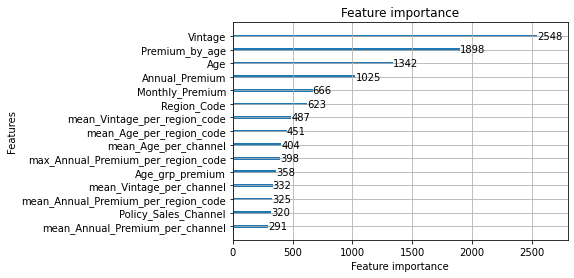

In [ ]:
lgb.plot_importance(model,max_num_features = 15)

In [ ]:
model = lgb.LGBMClassifier(random_state=0, n_estimators=200, 
                          learning_rate=0.1, num_leaves=31,
                          is_unbalance=True)
model.fit(X,y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', is_unbalance=True, learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [ ]:
y_pred_test = model.predict_proba(X_test)

In [ ]:
X.shape

(381109, 121)

In [ ]:
submission['Response_pred'] = y_pred_test[:,1]

In [ ]:
submission.shape

(127037, 3)

In [ ]:
submission.drop("Response",axis=1,inplace=True)

In [ ]:
submission.head()

,id,Response_pred
0,381110,0.000285
1,381111,0.786928
2,381112,0.754452
3,381113,0.040824
4,381114,0.000214


In [ ]:
submission.columns = ['id','Response']

In [ ]:
submission.to_csv("lgb_new.csv",index=False)

## Stack blend and undersample

In [99]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier, XGBRFClassifier
!pip install vecstack
from vecstack import StackingTransformer
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score

  Created wheel for vecstack: filename=vecstack-0.4.0-cp36-none-any.whl size=19880 sha256=8d816756ae493a9ec4ae681c87d23ed378613e3c9c5615f19952d0531dcb1fe8
  Stored in directory: /root/.cache/pip/wheels/5f/bb/4e/f6488433d53bc0684673d6845e5bf11a25240577c8151c140e
Successfully built vecstack


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [100]:
train1 = train.copy()
test1 = test.copy()

In [101]:
test1.shape

(127037, 124)

In [102]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License,Premium_by_age,mean_Age_per_insured_damage,sum_Age_per_insured_damage,max_Age_per_insured_damage,min_Age_per_insured_damage,mean_Annual_Premium_per_insured_damage,sum_Annual_Premium_per_insured_damage,max_Annual_Premium_per_insured_damage,min_Annual_Premium_per_insured_damage,mean_Vintage_per_insured_damage,sum_Vintage_per_insured_damage,max_Vintage_per_insured_damage,min_Vintage_per_insured_damage,mean_Age_per_insured_damage_license,sum_Age_per_insured_damage_license,max_Age_per_insured_damage_license,min_Age_per_insured_damage_license,mean_Annual_Premium_per_insured_damage_license,sum_Annual_Premium_per_insured_damage_license,max_Annual_Premium_per_insured_damage_license,min_Annual_Premium_per_insured_damage_license,mean_Vintage_per_insured_damage_license,sum_Vintage_per_insured_damage_license,max_Vintage_per_insured_damage_license,min_Vintage_per_insured_damage_license,Driving_License_per_Region_code,PreviouslyInsured_per_Region_code,VehicleDamage_per_Region_code,channel_users,channel_effort,Age_group,Age_grp_premium,Age_grp_premium1,customer_seg,Age_customer_seg,Revenue_customer_seg,Monthly_Premium,Vintage_weeks
0,1,0.334937,1,28.0,0,3,1,0.577348,26.0,0.748904,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,299,10,919.409091,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10,141486,44166,93767,32235,106594,7.0,31182.334555,17803.080293,5,55.114958,35654.103340,3371.166667,31
1,2,2.399430,1,3.0,0,2,0,0.173886,26.0,0.342540,0.0,1,0,1,36.980970,456678,82,20,24465.445218,3.021238e+08,424578.0,2630.0,154.864442,1912421,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,49.017962,13088531,...,299,10,441.263158,37.568585,1203998,84,20,27389.917904,8.777921e+08,337573.0,2630.0,154.398402,4948160,299,10,37.495621,1198810,84,20,27368.564682,8.750278e+08,337573.0,2630.0,154.385744,4936021,299,10,12328,6000,5937,32235,106594,17.0,34877.882420,19182.468086,2,38.580845,27488.904116,2794.666667,26
2,3,0.528483,1,28.0,0,3,1,0.451376,26.0,-1.521955,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,299,10,814.765957,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10,141486,44166,93767,32235,106594,8.0,31531.632683,18610.090269,5,55.114958,35654.103340,3191.166667,3
3,4,-1.148917,1,11.0,1,1,0,-0.112877,152.0,0.581577,0.0,1,0,1,34.235480,422055,82,20,27655.183160,3.409331e+08,193637.0,2630.0,154.520360,1904927,299,10,26.211884,4705636,80,20,30898.685511,5.547025e+09,49510

In [103]:
test1.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License,Premium_by_age,mean_Age_per_insured_damage,sum_Age_per_insured_damage,max_Age_per_insured_damage,min_Age_per_insured_damage,mean_Annual_Premium_per_insured_damage,sum_Annual_Premium_per_insured_damage,max_Annual_Premium_per_insured_damage,min_Annual_Premium_per_insured_damage,mean_Vintage_per_insured_damage,sum_Vintage_per_insured_damage,max_Vintage_per_insured_damage,min_Vintage_per_insured_damage,mean_Age_per_insured_damage_license,sum_Age_per_insured_damage_license,max_Age_per_insured_damage_license,min_Age_per_insured_damage_license,mean_Annual_Premium_per_insured_damage_license,sum_Annual_Premium_per_insured_damage_license,max_Annual_Premium_per_insured_damage_license,min_Annual_Premium_per_insured_damage_license,mean_Vintage_per_insured_damage_license,sum_Vintage_per_insured_damage_license,max_Vintage_per_insured_damage_license,min_Vintage_per_insured_damage_license,Driving_License_per_Region_code,PreviouslyInsured_per_Region_code,VehicleDamage_per_Region_code,channel_users,channel_effort,Age_group,Age_grp_premium,Age_grp_premium1,customer_seg,Age_customer_seg,Revenue_customer_seg,Monthly_Premium,Vintage_weeks
0,381110,-0.890855,1,11.0,1,1,0,0.305107,152.0,-1.211206,NaN,0,0,1,34.235480,422055,82,20,27655.183160,3.409331e+08,193637.0,2630.0,154.520360,1904927,299,10,26.211884,4705636,80,20,30898.685511,5.547025e+09,495106.0,2630.0,154.624338,27758625,299,10,24.824322,5456510,...,299,10,1431.440000,34.182770,7515082,85,20,30827.433491,6.777411e+09,540165.0,2630.0,154.435888,33952730,299,10,34.144448,7497711,85,20,30824.079704,6.768598e+09,540165.0,2630.0,154.438708,33912887,299,10,12314,7662,4386,131134,179523,1.0,30711.642041,15026.028501,0,26.155998,29913.830735,2982.166667,7
1,381111,0.076876,1,28.0,0,2,1,0.187066,7.0,-0.517996,NaN,0,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,54.721836,118035,85,26,37865.117756,8.167506e+07,200998.0,2630.0,154.631896,333541,299,10,49.017962,13088531,...,299,10,844.050000,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10,141486,44166,93767,919,2157,6.0,29648.750873,17734.256427,4,47.147577,35711.962077,2813.500000,15
2,381112,0.528483,1,28.0,0,2,1,0.553787,124.0,0.533770,NaN,0,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,46.894536,4609686,85,20,31680.202881,3.114132e+09,540165.0,2630.0,154.166757,15154438,299,10,49.017962,13088531,...,299,10,852.127660,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10,141486,44166,93767,28138,98299,8.0,31531.632683,18610.090269,6,44.574654,39622.828604,3337.500000,28
3,381113,-0.955370,1,27.0,1,1,1,0.396671,152.0,0.390347,NaN,0,0,1,30.233899,112198,80,20,22703.393425,8.425229e+07,108765.0,2630.0,151.118297,560800,299,10,26.211884,4705636,80,20,30898.685511,

In [117]:
def final_submission(X_train, Y, X_test):
    # Define base estimators for stacking
    estimators = [('lgbm', LGBMClassifier(random_state=0, n_estimators=500, 
                                      learning_rate=0.1, num_leaves=31,
                                      is_unbalance=True,eval_metric="AUC")),
              # ('rf', RandomForestClassifier(random_state=0, max_depth=10, 
              #                               class_weight={0:0.12, 1:0.88}, 
              #                               n_estimators=500, max_features=None, n_jobs=4)),
              # adding xgboost too in the stack
         #     ('xgb',XGBClassifier(random_state=0, n_jobs=4, max_depth=4, scale_pos_weight=2.5, n_estimators=200, learning_rate=0.1, gamma=1)),
              ('cat', CatBoostClassifier(scale_pos_weight=6, verbose=100,   # it was 500 estimators before 19/9
                                                  early_stopping_rounds=100,iterations=500))]
    # Perform stacking
    stack = StackingTransformer(estimators, regression=False, verbose=2, needs_proba=True, stratified=True, shuffle=True)
    stack = stack.fit(X_train, Y)

    # Get the stacked features
    S_train = stack.transform(X_train)
    S_test = stack.transform(X_test)
    # Also take the weighted average of the stacked features as another feature
    S_train_av, S_test_av = np.zeros((len(S_train), 2), dtype=np.float32), np.zeros((len(S_test), 2), dtype=np.float32)
    for index, vals in enumerate(S_train):
        S_train_av[index, 0] = (vals[0]*0.7) + (vals[2]*0.3)
        S_train_av[index, 1] = (vals[1]*0.7) + (vals[3]*0.3)
    for index, vals in enumerate(S_test):
        S_test_av[index, 0] = (vals[0]*0.7) + (vals[2]*0.3)
        S_test_av[index, 1] = (vals[1]*0.7) + (vals[3]*0.3)

    # Define the final estimator (catboost on 19/9)
    # model = CatBoostClassifier(scale_pos_weight=6, verbose=100,early_stopping_rounds=100,iterations=2500,eval_metric="AUC")
    model = XGBClassifier(random_state=0, n_jobs=4, max_depth=4, scale_pos_weight=2.5, n_estimators=200, learning_rate=0.1, gamma=1) #2.5
    model.fit(np.concatenate((S_train, S_train_av, X_train), axis=1), Y)
    preds4 =  model.predict_proba(np.concatenate((S_test, S_test_av, X_test), axis=1))

    # Now perform random under-sampling on the data
    rus = RandomUnderSampler(random_state=0, sampling_strategy=0.3)
    X_train_u, Y_u = rus.fit_resample(X_train, Y)

    # Get predictions from models on this majority class under-sampled dataset
    model1 = LGBMClassifier(random_state=0, n_estimators=100, learning_rate=0.1, num_leaves=31,eval_metric="AUC") #it was 100 before
   # model2 = CatBoostClassifier(verbose=100,early_stopping_rounds=100,iterations=2500, eval_metric="AUC", learning_rate=0.03) # added catboost on 19/9
    model2 = XGBClassifier(n_estimators=500,random_state=0,eval_metric='auc', learning_rate=0.1)
    model1.fit(X_train_u, Y_u), model2.fit(X_train_u, Y_u)
    preds1, preds2 = model1.predict_proba(X_test), model2.predict_proba(X_test)

    # Now perform random over-sampling on the data
    ros = RandomOverSampler(random_state=0, sampling_strategy=0.3)
    X_train_o, Y_o = ros.fit_resample(X_train, Y)

    # Get predictions from models on this majority class under-sampled dataset
    model3 = LGBMClassifier(random_state=0, n_estimators=100, learning_rate=0.1, num_leaves=31, eval_metric="AUC") #it was 100 before
 #   model4 = CatBoostClassifier(verbose=100,early_stopping_rounds=100,iterations=2500, eval_metric="AUC", learning_rate=0.03) # added catboost on 19/9
    model4 = XGBClassifier(n_estimators=500,random_state=0,eval_metric='auc', learning_rate=0.1)
    model3.fit(X_train_o, Y_o), model4.fit(X_train_o, Y_o)
    preds5, preds6 = model3.predict_proba(X_test), model4.predict_proba(X_test)

    # Get weighted average predictions
    preds3 = list()
    for a, b in zip(preds1, preds2):
        preds3.append([(0.7*a[0]) + (0.3*b[0]), (0.7*a[1]) + (0.3*b[1])])
    
    preds7 = list()
    for a, b in zip(preds5, preds6):
        preds7.append([(0.7*a[0]) + (0.3*b[0]), (0.7*a[1]) + (0.3*b[1])])
    
    preds37 = list()
    for a, b in zip(preds3, preds7):
        preds37.append([(0.5*a[0]) + (0.5*b[0]), (0.5*a[1]) + (0.5*b[1])])
    # Finally, perform weighted average prediction of stacked ensemble and weighted average ensemble
    preds = list()
    for a, b in zip(preds37, preds4):
        preds.append([(0.5*a[0]) + (0.5*b[0]), (0.5*a[1]) + (0.5*b[1])])
    preds = np.array(preds)

    return preds

In [118]:
X_train = np.array(train1.drop(['id','is_train','Response'],axis=1))
y_train = np.array(train1['Response'])
X_test = np.array(test1.drop(['id','is_train','Response'],axis=1))

In [119]:
preds = final_submission(X_train,y_train,X_test)

task:         [classification]
n_classes:    [2]
metric:       [log_loss]
variant:      [A]
n_estimators: [2]

estimator  0: [lgbm: LGBMClassifier]
    fold  0:  [0.45019738]
    fold  1:  [0.45709722]
    fold  2:  [0.45487119]
    fold  3:  [0.44519722]
    ----
    MEAN:     [0.45184075] + [0.00457305]

estimator  1: [cat: CatBoostClassifier]
0:	total: 160ms	remaining: 6m 40s
100:	total: 13.6s	remaining: 5m 23s
200:	total: 26.9s	remaining: 5m 8s
300:	total: 40s	remaining: 4m 52s
400:	total: 52.9s	remaining: 4m 36s
500:	total: 1m 5s	remaining: 4m 21s
600:	total: 1m 18s	remaining: 4m 7s
700:	total: 1m 30s	remaining: 3m 53s
800:	total: 1m 43s	remaining: 3m 39s
900:	total: 1m 56s	remaining: 3m 26s
1000:	total: 2m 9s	remaining: 3m 13s
1100:	total: 2m 21s	remaining: 3m
1200:	total: 2m 34s	remaining: 2m 47s
1300:	total: 2m 47s	remaining: 2m 34s
1400:	total: 3m	remaining: 2m 21s
1500:	total: 3m 13s	remaining: 2m 8s
1600:	total: 3m 26s	remaining: 1m 56s
1700:	total: 3m 39s	remaining: 1m 43s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0:	total: 97.3ms	remaining: 4m 3s
100:	total: 9.63s	remaining: 3m 48s
200:	total: 19s	remaining: 3m 37s
300:	total: 28.3s	remaining: 3m 26s
400:	total: 37.6s	remaining: 3m 16s
500:	total: 46.7s	remaining: 3m 6s
600:	total: 55.8s	remaining: 2m 56s
700:	total: 1m 4s	remaining: 2m 46s
800:	total: 1m 14s	remaining: 2m 37s
900:	total: 1m 23s	remaining: 2m 27s
1000:	total: 1m 32s	remaining: 2m 18s
1100:	total: 1m 41s	remaining: 2m 8s
1200:	total: 1m 50s	remaining: 1m 59s
1300:	total: 1m 59s	remaining: 1m 50s
1400:	total: 2m 8s	remaining: 1m 40s
1500:	total: 2m 17s	remaining: 1m 31s
1600:	total: 2m 26s	remaining: 1m 22s
1700:	total: 2m 35s	remaining: 1m 13s
1800:	total: 2m 44s	remaining: 1m 4s
1900:	total: 2m 53s	remaining: 54.8s
2000:	total: 3m 3s	remaining: 45.6s
2100:	total: 3m 12s	remaining: 36.5s
2200:	total: 3m 21s	remaining: 27.3s
2300:	total: 3m 30s	remaining: 18.2s
2400:	total: 3m 39s	remaining: 9.05s
2499:	total: 3m 48s	remaining: 0us


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0:	total: 211ms	remaining: 8m 47s
100:	total: 19.6s	remaining: 7m 45s
200:	total: 38.1s	remaining: 7m 15s
300:	total: 56.8s	remaining: 6m 54s
400:	total: 1m 15s	remaining: 6m 33s
500:	total: 1m 33s	remaining: 6m 12s
600:	total: 1m 51s	remaining: 5m 51s
700:	total: 2m 9s	remaining: 5m 31s
800:	total: 2m 27s	remaining: 5m 12s
900:	total: 2m 45s	remaining: 4m 54s
1000:	total: 3m 3s	remaining: 4m 35s
1100:	total: 3m 21s	remaining: 4m 16s
1200:	total: 3m 39s	remaining: 3m 57s
1300:	total: 3m 58s	remaining: 3m 39s
1400:	total: 4m 16s	remaining: 3m 21s
1500:	total: 4m 34s	remaining: 3m 2s
1600:	total: 4m 53s	remaining: 2m 44s
1700:	total: 5m 11s	remaining: 2m 26s
1800:	total: 5m 29s	remaining: 2m 8s
1900:	total: 5m 48s	remaining: 1m 49s
2000:	total: 6m 6s	remaining: 1m 31s
2100:	total: 6m 25s	remaining: 1m 13s
2200:	total: 6m 44s	remaining: 54.9s
2300:	total: 7m 3s	remaining: 36.7s
2400:	total: 7m 23s	remaining: 18.3s
2499:	total: 7m 43s	remaining: 0us


In [120]:
preds.shape

(127037, 2)

In [121]:
submission['Response_pred'] = preds[:,1]

In [122]:
submission.shape

(127037, 3)

In [123]:
submission.drop("Response",axis=1,inplace=True)

In [124]:
submission.head()

,id,Response_pred
0,381110,0.002846
1,381111,0.650533
2,381112,0.592118
3,381113,0.041333
4,381114,0.001920


In [125]:
submission.columns = ['id','Response']

In [126]:
submission.to_csv("lgb_vecstack_catboost_v1.csv",index=False)